<a href="https://colab.research.google.com/github/vipul43/image_description/blob/main/image_description.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# installs

In [6]:
# imports
import scipy.io
import cv2
from google.colab.patches import cv2_imshow
from skimage import io
import numpy as np
import pandas as pd
from PIL import Image 
import matplotlib.pylab as plt
import pickle
from skimage import transform
from sklearn.model_selection import train_test_split
import tensorflow as tf
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, LancasterStemmer
import spacy
import nltk
import keras.backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import re

In [7]:
nltk.download('punkt') #tokenizer
nltk.download('wordnet') #lemmatization

lemmatizer = WordNetLemmatizer() #lemmatizer

sp = spacy.load('en_core_web_sm') #lexical importance find

ls = LancasterStemmer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
# data loading
!gdown --id 1mrjvJq6XNM8QAgajSgrVGpsj8Vrm3BEm #PASCAL50S

mat = scipy.io.loadmat('/content/pascal50S.mat')

In [11]:
#creating tokenizer on the dataset
stringX2 = []
stop_words = ["a", "the", "is", "be", "will"]
for sample in mat["train_sent_final"][0]:
  for k in sample[1]:
    for sent in k:
      new_sent = "<start> "
      sentence = re.sub(r'[^\w\s]','',sent[0])
      sentence = ' '.join([word for word in sentence.split() if word not in stop_words])  #removing stop words
      for word in sentence.split():
        pre_word = lemmatizer.lemmatize(word.lower())
        new_sent+=pre_word+" "
      new_sent+="<end>"
      stringX2.append(new_sent)

tk = Tokenizer(filters='')
tk.fit_on_texts(stringX2)
print(len(tk.word_index))

6801


In [47]:
#preprocessing data
data = []
stop_words=['the', 'a', 'and', 'is', 'be', 'will']
for sample in mat["train_sent_final"][0]:
  link = sample[0][0]
  i=0
  for sent in sample[1][0]:
    i+=1
    new_sent = "<start> "
    sentence = re.sub(r'[^\w\s]','',sent[0])
    sentence = ' '.join([word for word in sentence.split() if word not in stop_words])  #removing stop words
    for word in sentence.split():
      pre_word = lemmatizer.lemmatize(word.lower())
      new_sent+=pre_word+" "
    new_sent+="<end>"
    data.append([link, new_sent])
    if(i==10):
      break
print(len(data))
print(data[:10])

10000
[['https://filebox.ece.vt.edu/~vrama91/PASCAL/2008_006488.jpg', '<start> man in boat fishing <end>'], ['https://filebox.ece.vt.edu/~vrama91/PASCAL/2008_006488.jpg', '<start> man fishing out of canoe <end>'], ['https://filebox.ece.vt.edu/~vrama91/PASCAL/2008_006488.jpg', '<start> a lone fisherman in rowboat on an empty lake <end>'], ['https://filebox.ece.vt.edu/~vrama91/PASCAL/2008_006488.jpg', '<start> a person fishing in boat on lake <end>'], ['https://filebox.ece.vt.edu/~vrama91/PASCAL/2008_006488.jpg', '<start> a man fishing in river <end>'], ['https://filebox.ece.vt.edu/~vrama91/PASCAL/2008_006488.jpg', '<start> a man fishing in canoe on lake <end>'], ['https://filebox.ece.vt.edu/~vrama91/PASCAL/2008_006488.jpg', '<start> a man fish in canoe in an empty lake <end>'], ['https://filebox.ece.vt.edu/~vrama91/PASCAL/2008_006488.jpg', '<start> a man in canoe fishing <end>'], ['https://filebox.ece.vt.edu/~vrama91/PASCAL/2008_006488.jpg', '<start> a person in canoe fish on lake <end>

#**Model**

In [48]:
# model making(Image to Vector)
# input layer
input1 = tf.keras.Input(shape=(224, 224, 3), name='input1')

# Transfer Learning with VGG16 model with weights as imagenet
vgg16 = tf.keras.applications.VGG16(include_top=False, weights="imagenet", classes=20)
vgg16.trainable = False
x = vgg16(input1)

# Dense Layers
x = tf.keras.layers.Flatten(name='flatten')(x)
x = tf.keras.layers.BatchNormalization(name='norm1')(x)
x = tf.keras.layers.Dense(192, activation='relu', name='dense1')(x)
x = tf.keras.layers.BatchNormalization(name='norm2')(x)
x = tf.keras.layers.Dense(84, activation='relu', name='dense2')(x)
x = tf.keras.layers.BatchNormalization(name='norm3')(x)
x = tf.keras.layers.Dense(64, activation='relu', name='dense3')(x)
x = tf.keras.layers.BatchNormalization(name='norm4')(x)

#Output layer
output = tf.keras.layers.Dense(500, activation="linear", name='output')(x)

model1 = tf.keras.models.Model(inputs=input1, outputs=output, name='model1')

model1.summary()

Model: "model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input1 (InputLayer)          [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
norm1 (BatchNormalization)   (None, 25088)             100352    
_________________________________________________________________
dense1 (Dense)               (None, 192)               4817088   
_________________________________________________________________
norm2 (BatchNormalization)   (None, 192)               768       
_________________________________________________________________
dense2 (Dense)               (None, 84)                16212

In [51]:
INP_LEN1 = 100 #(Text to Vector)
input2 = tf.keras.Input(shape=(INP_LEN1,), name='input')
embed = tf.keras.layers.Embedding((len(tk.word_counts)+1),INP_LEN1)(input2)
rnn1 = tf.keras.layers.LSTM(192, return_sequences=True, dropout=0.3)(embed)
pool = tf.keras.layers.MaxPool1D()(rnn1)
rnn2 = tf.keras.layers.LSTM(128, dropout=0.2)(pool)
dense1 = tf.keras.layers.Dense(84, activation='relu')(rnn2)
drop1 = tf.keras.layers.Dropout(0.2)(dense1)
norm1 = tf.keras.layers.BatchNormalization()(drop1)
output = tf.keras.layers.Dense(500, activation='linear')(norm1)

model2 = tf.keras.models.Model(inputs=input2, outputs=output, name='model2')
model2.summary()


Model: "model2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 100)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 100)          680200    
_________________________________________________________________
lstm (LSTM)                  (None, 100, 192)          225024    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 50, 192)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               164352    
_________________________________________________________________
dense_8 (Dense)              (None, 84)                10836     
_________________________________________________________________
dropout_2 (Dropout)          (None, 84)                0    

**Concatenating the Image Model(Model1) and Text Model(Model2)**

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, None, None, 5 14714688    input1[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 25088)        0           vgg16[0][0]                      
__________________________________________________________________________________________________
input (InputLayer)              [(None, 100)]        0                                            
____________________________________________________________________________________________

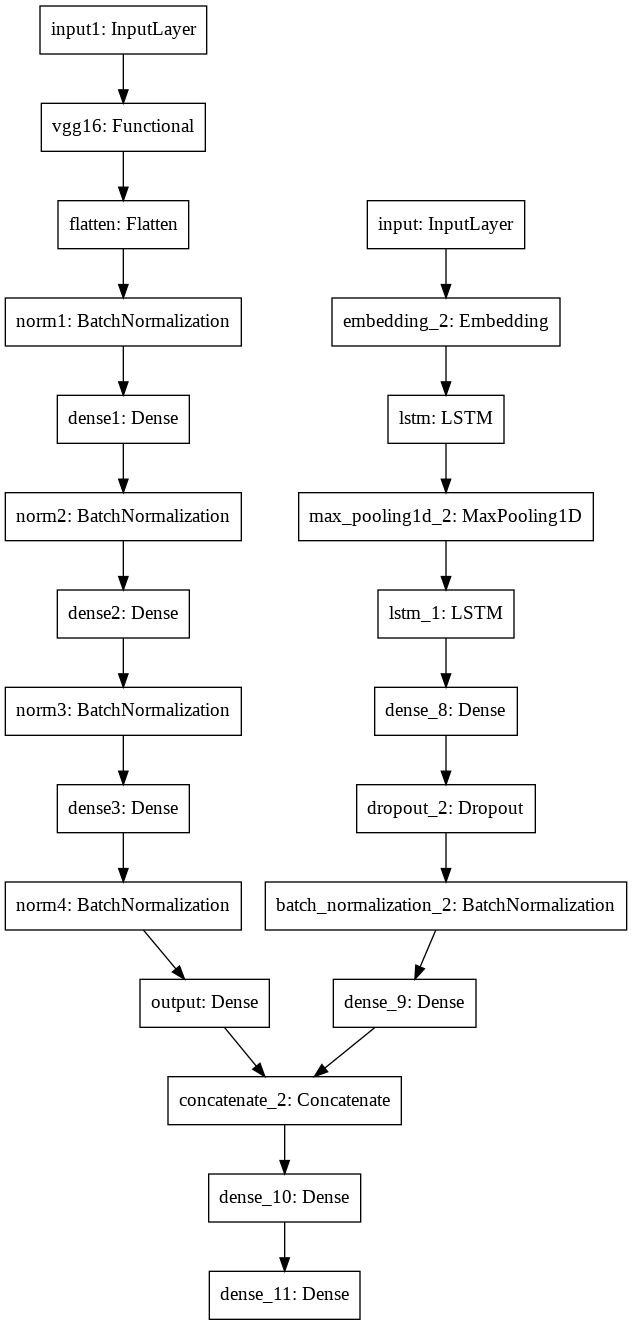

In [52]:
concate = tf.keras.layers.Concatenate(axis=-1)([model1.output, model2.output])
final_dense = tf.keras.layers.Dense(256, activation='relu')(concate)
Output = tf.keras.layers.Dense(len(tk.word_counts)+1, activation='softmax')(final_dense)
finalModel  = tf.keras.models.Model(inputs=[input1,input2],outputs=Output)

finalModel.summary()
tf.keras.utils.plot_model(finalModel,to_file="finalModel.png")

**Train the MultiModal**

In [53]:
#data generator to 
def data_generator(data, tk, new_shape, batch_size):
  X1, X2, y = list(), list(), list()
  n = 0
  while 1:
    for point in data:
      n+=1
      photo = io.imread(point[0])
      photo = transform.resize(image=photo, output_shape=new_shape)
      sent = point[1]
      seq = [tk.word_index[word] for word in sent.split(' ') if word in tk.word_index.keys()]
      for i in range(1, len(seq)):
        in_seq, out_seq = seq[:i], seq[i]
        in_seq = pad_sequences([in_seq], maxlen=100, padding='post')[0]
        out_seq = to_categorical([out_seq], num_classes=len(tk.word_index)+1)[0]
        X1.append(photo)
        X2.append(in_seq)
        y.append(out_seq)
      if n == batch_size:
        yield ([np.asarray(X1), np.asarray(X2)], np.asarray(y))
        X1, X2, y = list(), list(), list()
        n=0

In [54]:
finalModel.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.0001), loss='categorical_crossentropy')

In [55]:
batch_size = 16
generator = data_generator(data,tk, (224, 224, 3), batch_size)
finalModel.fit(generator, epochs=5, shuffle=True)
# batches = (53500/batch_size)

Epoch 1/10
     13/Unknown - 130s 10s/step - loss: 8.8182

KeyboardInterrupt: ignored

**Predictions**

In [56]:
index_word = dict(map(reversed, tk.word_index.items()))
def predict(image):
  partial_caption = "<start>"
  for i in range(100):
    seq = [tk.word_index[word] for word in partial_caption.split() if word in tk.word_index.keys()]
    seq = pad_sequences([seq], maxlen=100)
    yhat = finalModel.predict([np.expand_dims(image, 0),[seq]], verbose=0)
    yhat = np.argmax(yhat)
    word = index_word[yhat]
    partial_caption += (' ' + word)
    if word == "<end>":
        break
  final_caption = partial_caption.split()[1:-1]
  final_caption = ' '.join(final_caption)
  return final_caption

original label  <start> the front view of blue party bus parked on road <end>
predicted label  craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning craning


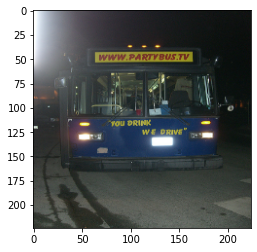

In [57]:
idx = np.random.randint(len(data))
photo = io.imread(data[idx][0])
photo = transform.resize(image=photo, output_shape=(224, 224, 3))
label = data[idx][1]
pred = predict(photo)
plt.imshow(photo)
print("original label ", label)
print("predicted label ", pred)

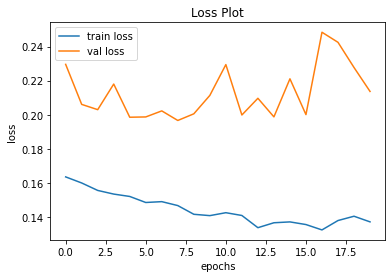

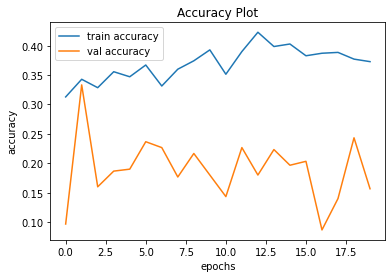

In [ ]:
# plotting curves
'''
loss -> train, val
accuracy -> train, val
'''
plt.plot(list(history.history.values())[0])
plt.plot(list(history.history.values())[2])
plt.title('Loss Plot')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train loss', 'val loss'])
plt.show()

plt.plot(list(history.history.values())[1])
plt.plot(list(history.history.values())[3])
plt.title('Accuracy Plot')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train accuracy', 'val accuracy'])
plt.show()